In [1]:
import torch, torchvision
from torch import nn
import torchvision.transforms as T

import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from lib.ResNet import ResNet50
from utils.data_loader import get_loader
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
class MNISTConfig():

    EPOCHS = 10

    BATCH_SIZE = 256

    LR = 1e-3

    WEIGHT_DECAY = 1e-3

    DECAY_RATE = 0.1

    DECAY_EPOCH = 5

    DATA_PATH = 'datasets'

    SAVE_PATH = 'models'

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        (0.1307,), (0.3081,)
    )
])

In [4]:
train_loader, val_loader = get_loader(root_dir=MNISTConfig.DATA_PATH,
                                      transform=transform,
                                      train=True,
                                      batchsize=MNISTConfig.BATCH_SIZE)

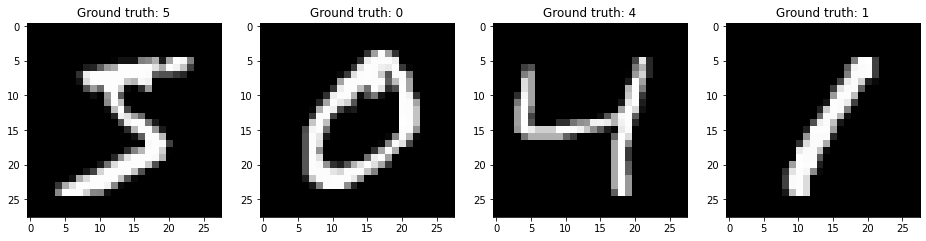

In [5]:
# Show first 4 images
for imgs, gts in train_loader:
    plt.figure(figsize=(16, 16))
    plt.subplot(141)
    plt.title('Ground truth: {}'.format(gts[0]))
    plt.imshow(imgs[0][0], cmap='gray')
    plt.subplot(142)
    plt.title('Ground truth: {}'.format(gts[1]))
    plt.imshow(imgs[1][0], cmap='gray')
    plt.subplot(143)
    plt.title('Ground truth: {}'.format(gts[2]))
    plt.imshow(imgs[2][0], cmap='gray')
    plt.subplot(144)
    plt.title('Ground truth: {}'.format(gts[3]))
    plt.imshow(imgs[3][0], cmap='gray')
    plt.show()
    break

In [6]:
cross_entory_loss = nn.CrossEntropyLoss()
softmax = nn.LogSoftmax(dim=-1)

def loss_fn(y_pred, y_true):
    y_pred = softmax(y_pred)
    return cross_entory_loss(y_pred, y_true)

In [7]:
def adjust_lr(optimizer, epoch, decay_rate=0.1, decay_epoch=30):
    if epoch % decay_epoch == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= decay_rate

In [8]:
def train(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0.0
    tbar = tqdm(train_loader, desc='\r')
    for i, packs in enumerate(tbar, start=1):
        optimizer.zero_grad()

        # Data preparation
        imgs, gts = packs
        imgs = imgs.cuda()
        gts = gts.cuda()

        # Forward
        preds = model(imgs)

        # Calculate loss
        loss = loss_fn(preds, gts)
        train_loss += loss

        # Backward
        loss.backward()
        optimizer.step()

        # Show train loss
        tbar.set_description("Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Train_loss: {:.4f}"
                .format(epoch, MNISTConfig.EPOCHS, i, len(train_loader), train_loss / i))

In [9]:
def evaluation(val_loader, model, epoch, best_val_loss):
    model.eval()
    val_loss = 0.0
    tbar = tqdm(val_loader, desc='\r')
    with torch.no_grad():
        for i, packs in enumerate(tbar, start=1):
            # Data preparation
            imgs, gts = packs
            imgs = imgs.cuda()
            gts = gts.cuda()

            # Forward
            preds = model(imgs)

            # Calculate val loss
            loss = loss_fn(preds, gts)
            val_loss += loss

            # Show validation loss
            tbar.set_description("Step [{:04d}/{:04d}], Val_loss: {:.4f}"
                .format(i, len(val_loader), val_loss / i))

        if val_loss / len(val_loader) < best_val_loss[-1]:
            os.makedirs(MNISTConfig.SAVE_PATH, exist_ok=True)
            best_val_loss.append(val_loss / len(val_loader))
            print('Curren Best Val_loss: {}, Saving Best Model: {}'.format(best_val_loss[-1], os.path.join(MNISTConfig.SAVE_PATH, 'model-best.pth')))
            torch.save(model.state_dict(), os.path.join(MNISTConfig.SAVE_PATH, 'model-best.pth'))

In [10]:
model = ResNet50(1, 10)
model = model.cuda()
parameters = model.parameters()
optimizer = torch.optim.AdamW(parameters, lr=MNISTConfig.LR, weight_decay=MNISTConfig.WEIGHT_DECAY)

In [11]:
best_val_loss = [10]
for epoch in range(1, MNISTConfig.EPOCHS+1):
    adjust_lr(optimizer, epoch, MNISTConfig.DECAY_RATE, MNISTConfig.DECAY_EPOCH)
    train(train_loader, model, optimizer, epoch)
    evaluation(val_loader, model, epoch, best_val_loss)

Epoch [001/010], Step [0188/0188], Train_loss: 0.2747: 100%|██████████| 188/188 [00:17<00:00, 11.05it/s]
Step [0047/0047], Val_loss: 0.1195: 100%|██████████| 47/47 [00:00<00:00, 55.67it/s]
Epoch [002/010], Step [0188/0188], Train_loss: 0.0642: 100%|██████████| 188/188 [00:17<00:00, 10.49it/s]
Step [0047/0047], Val_loss: 0.1768: 100%|██████████| 47/47 [00:00<00:00, 55.14it/s]
Epoch [003/010], Step [0188/0188], Train_loss: 0.0467: 100%|██████████| 188/188 [00:17<00:00, 10.62it/s]
Step [0047/0047], Val_loss: 0.1342: 100%|██████████| 47/47 [00:00<00:00, 54.19it/s]
Epoch [004/010], Step [0188/0188], Train_loss: 0.0335: 100%|██████████| 188/188 [00:17<00:00, 10.78it/s]
Step [0047/0047], Val_loss: 0.0997: 100%|██████████| 47/47 [00:00<00:00, 53.60it/s]
Epoch [005/010], Step [0188/0188], Train_loss: 0.0108: 100%|██████████| 188/188 [00:17<00:00, 10.81it/s]
Step [0047/0047], Val_loss: 0.0462: 100%|██████████| 47/47 [00:00<00:00, 54.20it/s]
Epoch [006/010], Step [0188/0188], Train_loss: 0.0030: 

Curren Best Val_loss: 0.11946222186088562, Saving Best Model: models/model-best.pth
Curren Best Val_loss: 0.09974803775548935, Saving Best Model: models/model-best.pth
Curren Best Val_loss: 0.04620501771569252, Saving Best Model: models/model-best.pth


In [12]:
test_loader = get_loader(root_dir=MNISTConfig.DATA_PATH,
                         transform=transform,
                         train=False,
                         batchsize=MNISTConfig.BATCH_SIZE)

In [13]:
model = ResNet50(1, 10)
model.load_state_dict(torch.load('models/model-best.pth'))
model = model.cuda()
model = model.eval()

In [14]:
# Evaluation on test dataset
with torch.no_grad():
    precision, recall, f1 = 0.0, 0.0, 0.0
    tbar = tqdm(test_loader, desc='\r')
    for i, packs in enumerate(tbar, start=1):
        imgs, gts = packs
        imgs = imgs.cuda()
        gts = gts.cpu().numpy()
        preds = model(imgs)
        preds = softmax(preds)
        preds = preds.cpu().numpy()
        preds = np.argmax(preds, axis=1)
        precision += precision_score(preds, gts, average='macro')
        recall += recall_score(preds, gts, average='macro')
        f1 += f1_score(preds, gts, average='macro')
        tbar.set_description("Precision Score: {}, Recall Score: {}, F1 Score: {}"
                             .format(precision / i, recall / i, f1 / i))

Precision Score: 0.9910056915601974, Recall Score: 0.9906097715030319, F1 Score: 0.9905661220124303: 100%|██████████| 40/40 [00:00<00:00, 49.40it/s]


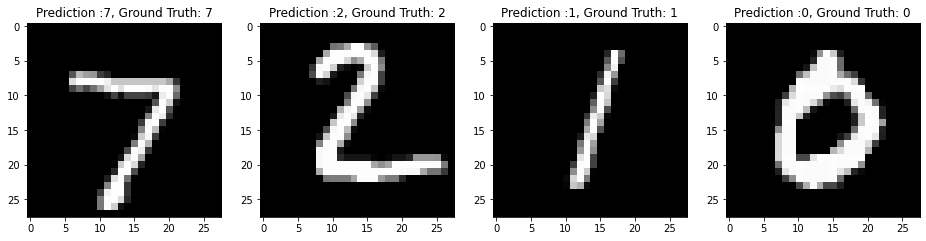

In [17]:
# Inference on first 4 test images
for imgs, gts in test_loader:
    with torch.no_grad():
        imgs, gts = imgs.cuda(), gts.cpu().numpy()
        preds = model(imgs)
        preds = softmax(preds)
        preds = preds.cpu().numpy()
        preds = np.argmax(preds, axis=1)
        imgs = imgs.cpu().numpy()
        plt.figure(figsize=(16, 16))
        plt.subplot(141)
        plt.title('Prediction :{}, Ground Truth: {}'.format(preds[0], gts[0]))
        plt.imshow(imgs[0][0], cmap='gray')
        plt.subplot(142)
        plt.title('Prediction :{}, Ground Truth: {}'.format(preds[1], gts[1]))
        plt.imshow(imgs[1][0], cmap='gray')
        plt.subplot(143)
        plt.title('Prediction :{}, Ground Truth: {}'.format(preds[2], gts[2]))
        plt.imshow(imgs[2][0], cmap='gray')
        plt.subplot(144)
        plt.title('Prediction :{}, Ground Truth: {}'.format(preds[3], gts[3]))
        plt.imshow(imgs[3][0], cmap='gray')
        plt.show()
    break